# Homework 03: Learning Curves and Training Workflow

## Due: Midnight on September 21 (with 2-hour grace period)

**Points:** 85

In this assignment, you will learn how to design, train, and evaluate neural networks by systematically exploring key design choices. Your focus will be on developing an effective **training workflow** — using learning curves and validation metrics to guide your decisions.

We'll use the **Forest Cover Type (Covertype) dataset,** which has ~581k tabular records with 54 cartographic/topographic features (elevation, aspect, slope, soil and wilderness indicators) used to predict one of seven tree cover types in Colorado’s Roosevelt National Forest. It’s a large, mildly imbalanced multi-class benchmark commonly used to compare classical ML and deep learning on tabular data.

We will start with a **baseline model** (two hidden layers of sizes 64 and 32), and gradually introduce and tune different hyperparameters. Each of the first five problems considers  different hyperparameter choices, and the last problem is your chance to use what you have learned to design your best model:

1. **Activation function** – Compare ReLU, sigmoid, and tanh to see which provides the best accuracy.
2. **Learning rate** – Explore a range of learning rates and identify which balances convergence speed and stability.
3. **Dropout** – Investigate how different dropout rates reduce overfitting and where they are most effective.
4. **L2 regularization** – Experiment with weight penalties to encourage simpler models and avoid memorization.
5. **Dropout + L2** – Combine both regularization techniques and study their interaction.
6. **Best model design** – Use all your insights to build and train your strongest model, with the option to try **learning rate scheduling** for further improvement.

Throughout, you will use **early stopping** to select the model at the epoch of **minimum validation loss**, and you will report the **validation accuracy** of that selected model as the primary measure of performance.

By the end of this homework, you will not only understand how different hyperparameters affect training and generalization, but also gain hands-on practice in building a disciplined workflow for model development.

There are 10 graded problems, worth 8 points each, with 5 points for free if you complete the homework. 

In [3]:
# Useful imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import os

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay


from tensorflow.keras.datasets import fashion_mnist

# utility code

random_seed = 42

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages


2025-09-22 01:26:54.264253: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-22 01:26:55.003747: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-22 01:26:57.693845: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [4]:
# Utility function to plot learning curves and keep track of all results

# Call `print_results()` to see listing of all results logged so far


def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,{min_val_epoch + 1})

results = {}

**The plotting function will record the validation accuracy for each experiment, using the plot title as key. The next function will print these out (see the last cell in the notebook).**


In order to see all results, you must give a different plot title to each experiment.

In [5]:
def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}")

### Wrapper to train, display results, and run test set

We assume multi-class classification, and allow setting various parameters for training. 

In [6]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model, 
                   epochs        = 500,                   # Just needs to be bigger than early stop point
                   lr_schedule   = 0.001,                 # Adam default / 10 seems to work well for this dataset
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 64,                     # experiments confirmed this was optimal with other parameters at default
                   use_early_stopping = True,
                   patience      = 10,                                       
                   min_delta     = 0.0001,                 
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule) 
    else:
        opt = optimizer
    
    #Compiling the model
    model.compile(optimizer=opt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )
    

    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()
    
    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),       # must use stratified validation set
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]
    
    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")
    
    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the dataset and extract a stratified subset

This datasest is rather large (581,012 samples) and unbalanced, but for the purposes of this homework, we use a much smaller set, and select samples so that it is balanced. 

In [7]:
# complete cell: load, balance, split into X_train/y_train/x_val/y_val/X_test/y_test, and standardize
from collections import Counter
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1) load
x, y = fetch_covtype(return_X_y=True)  # y in {1..7}
print("full dataset shape:", x.shape)

# 2) build a perfectly balanced subset across 7 classes (no replacement)
classes, counts = np.unique(y, return_counts=True)
# min_count = counts.min()  # size of rarest class                         # You can modify this parameter to increase the size of the dataset, but above
min_count = 1000                                                           # counts.min() you'll produce an unbalanced set. 


rng = np.random.default_rng(42)

idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = x[idx_bal]
y_sub = y[idx_bal] - 1  # relabel to {0..6} for keras
print("balanced subset shape:", X_sub.shape, "class counts:", dict(Counter(y_sub)))

# 3) stratified 60/20/20 split (train/val/test)
test_size = 0.20
val_size = 0.20  # of the whole dataset

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_sub, y_sub, test_size=test_size, random_state=random_seed, stratify=y_sub
)
val_size_rel = val_size / (1.0 - test_size)  # e.g., 0.20 / 0.80 = 0.25

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_size_rel, random_state=random_seed, stratify=y_trainval
)

# 4) standardize using train-only stats (float32 for tensorflow friendliness)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

# 5) quick sanity checks
def show_counts(name, y_arr):
    c = Counter(y_arr)
    total = sum(c.values())
    print(f"{name}: total={total}, per-class={dict(c)}")

print("shapes:", "X_train", X_train.shape, "X_val", X_val.shape, "X_test", X_test.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

# you now have: X_train, y_train, X_val, y_val, X_test, y_test

# Looks like integer encoded multi-class, let's check and define the global n_classes

labels = np.unique(y_train)

n_classes = len(labels)

print("class labels:",labels)


full dataset shape: (581012, 54)
balanced subset shape: (7000, 54) class counts: {np.int32(2): 1000, np.int32(0): 1000, np.int32(4): 1000, np.int32(5): 1000, np.int32(1): 1000, np.int32(3): 1000, np.int32(6): 1000}
shapes: X_train (4200, 54) X_val (1400, 54) X_test (1400, 54)
train: total=4200, per-class={np.int32(2): 600, np.int32(1): 600, np.int32(0): 600, np.int32(3): 600, np.int32(5): 600, np.int32(4): 600, np.int32(6): 600}
val  : total=1400, per-class={np.int32(1): 200, np.int32(6): 200, np.int32(5): 200, np.int32(4): 200, np.int32(3): 200, np.int32(2): 200, np.int32(0): 200}
test : total=1400, per-class={np.int32(0): 200, np.int32(6): 200, np.int32(2): 200, np.int32(3): 200, np.int32(4): 200, np.int32(5): 200, np.int32(1): 200}
class labels: [0 1 2 3 4 5 6]


## Prelude: Defining a model builder

In order to facilitate our experimentation, we'll write a function which builds models according to specifications:

- How many layers
- How wide each layer is
- How much dropout in each layer
- How much L2 Regularization in each layer

This is a fairly standard practice in ML, since the structure of simple models is fairly predictable and can be specified by a few hyperparameters. 

In [8]:
# This function will build a multi-class classifier with dropout and L2 regularization.
# You must specify the number of input features, the number of classes, and a list of layer hyperparameters
# in the form  [ ...., (width, activation function, L2 lambda, dropout rate), .... ]

# Note that when adding dropout, this appears as a separate layer, but it has no parameters to be trained. 

def build_model(n_inputs,layer_list,n_classes):
    layers = [ Input(shape=(n_inputs,)) ]
    for (width,act,l2_lambda,dropout_rate) in layer_list:
        layers.append( Dense(width, activation=act, kernel_regularizer=regularizers.l2(l2_lambda)) )
        if dropout_rate > 0:
            layers.append( Dropout(dropout_rate) )
    layers.append( Dense(n_classes, activation='softmax') )
    return models.Sequential( layers )


**Example: To build the following model:**

In [9]:
model = models.Sequential(
   [
    Input(shape=(X_train.shape[1],)),                              
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0)),              # 0.0 means no regularization applied; no dropout, so no Dropout layer necessary
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
   ]
)

model.summary()

2025-09-22 01:31:42.860906: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

**We call `build_model` as shown here:**

In [10]:
build_model(X_train.shape[1], [ (64,'relu',0.0,0.0), (32,'relu',0.001,0.3)], n_classes).summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

-------------------



### Baseline Model Architecture

**Problems 1–5 will use the following baseline model structure,** implemented with the provided `build_model` function and trained using `train_and_test`:

```
input → 64 → 32 → output
```

* Two hidden layers of widths 64 and 32.
* Activation function, dropout rate, and L2 regularization term (λ) will vary as specified in each problem.
* **Early stopping** is always applied to select the model at the epoch of **minimum validation loss**.
* We will report the **validation accuracy** of the selected model as the primary metric.


### Problem One: Which Activation Function?

In this problem, you will train the **baseline neural network** and investigate which activation function produces the best performance. The model you create will be the one saved by **early stopping** — that is, the epoch where validation loss is minimized.

**Steps to follow:**

* Use the provided functions `train_and_test` and `build_model` to create a model named **`model_baseline`**.
* Train and evaluate this model using each of the following activation functions in the hidden layers:

  * `relu`
  * `sigmoid`
  * `tanh`
* Identify which activation function produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Baseline ReLU



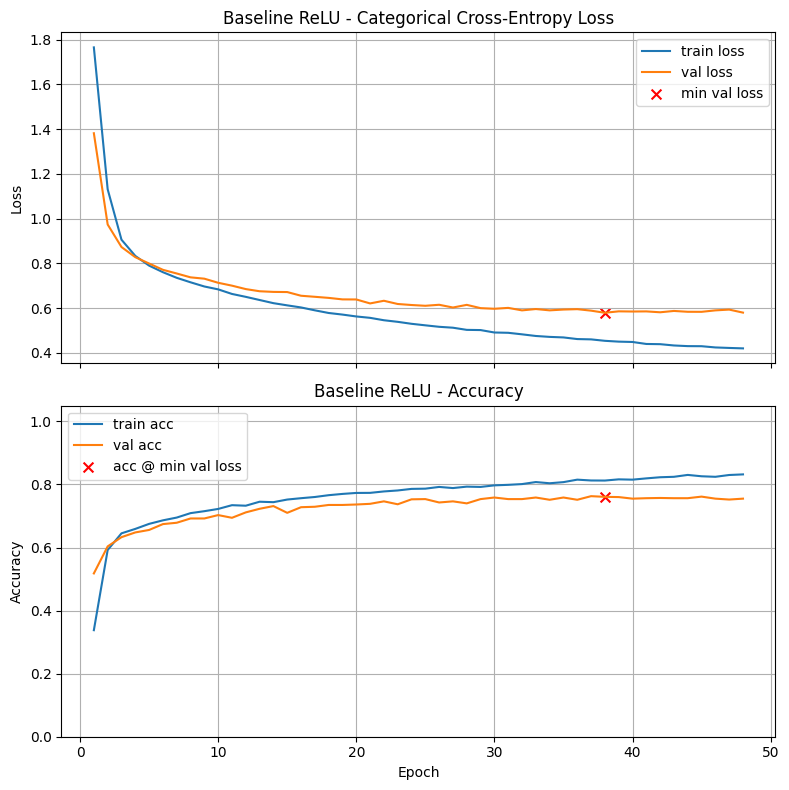

Final Training Loss:            0.4205
Final Training Accuracy:        0.8319
Final Validation Loss:          0.5802
Final Validation Accuracy:      0.7550
Minimum Validation Loss:        0.5795 (Epoch 38)
Validation Accuracy @ Min Loss: 0.7607

Test Loss: 0.6093
Test Accuracy: 0.7436

Validation-Test Gap (accuracy): 0.017143

Execution Time: 00:00:09

Baseline Sigmoid



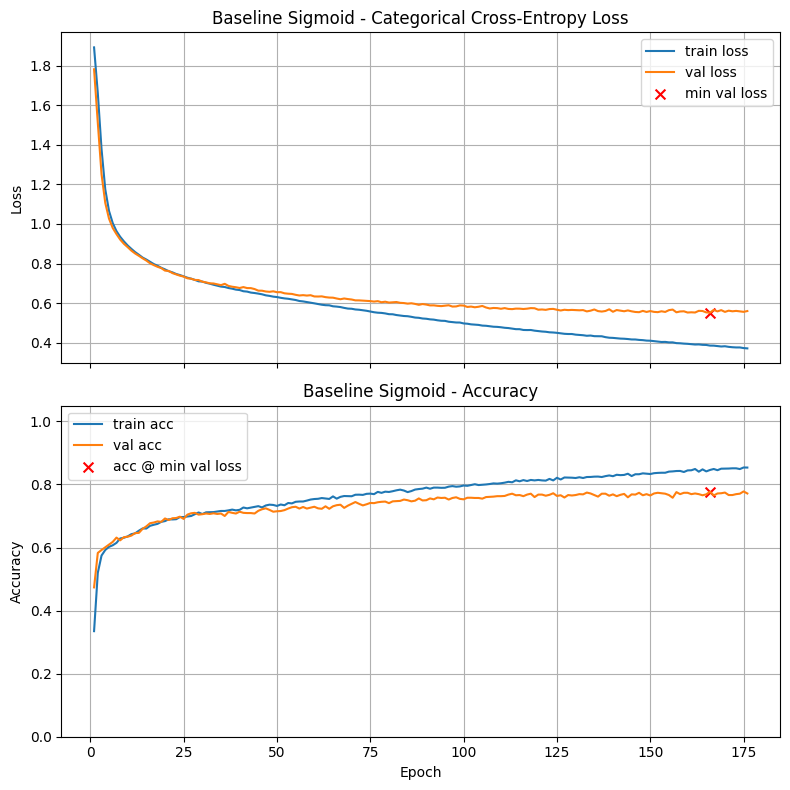

Final Training Loss:            0.3718
Final Training Accuracy:        0.8536
Final Validation Loss:          0.5603
Final Validation Accuracy:      0.7714
Minimum Validation Loss:        0.5523 (Epoch 166)
Validation Accuracy @ Min Loss: 0.7771

Test Loss: 0.5708
Test Accuracy: 0.7679

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:00:28

Baseline Tanh



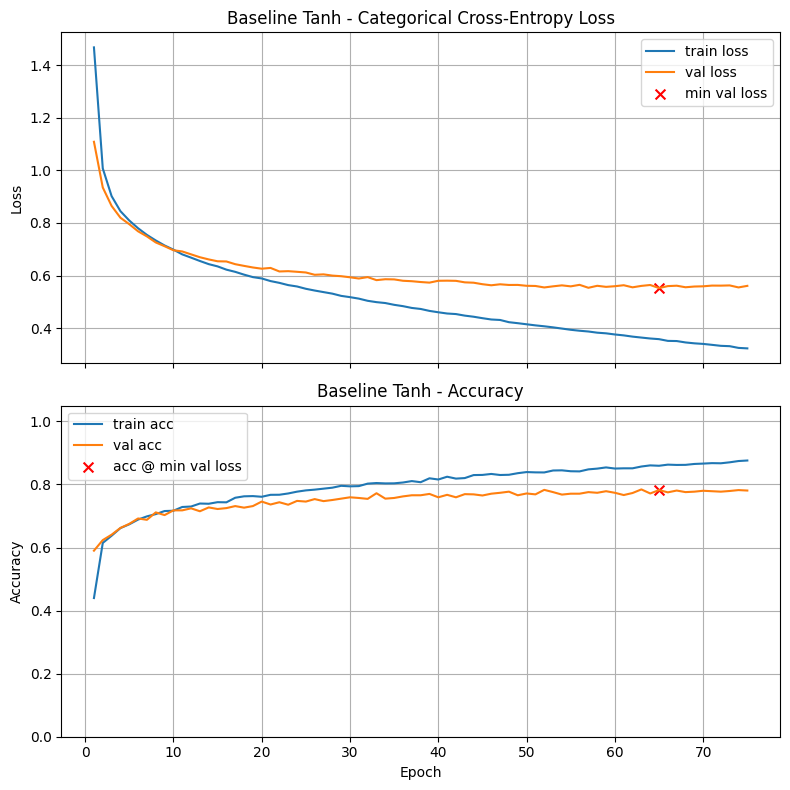

Final Training Loss:            0.3232
Final Training Accuracy:        0.8760
Final Validation Loss:          0.5609
Final Validation Accuracy:      0.7807
Minimum Validation Loss:        0.5525 (Epoch 65)
Validation Accuracy @ Min Loss: 0.7821

Test Loss: 0.5566
Test Accuracy: 0.7707

Validation-Test Gap (accuracy): 0.011429

Execution Time: 00:00:12

=== Validation accuracy at min val loss ===
Baseline Tanh                           	0.7821
Baseline Sigmoid                        	0.7771
Baseline ReLU                           	0.7607


In [11]:
# Your code here. Add as many cells as you need. 
# base_model = build_model(lr=lr_schedule)

results.clear()

# 1. ReLU
model_relu = build_model(
    n_inputs=X_train.shape[1],
    layer_list=[(64,'relu',0.0,0.0), (32,'relu',0.0,0.0)],
    n_classes=n_classes
)
train_and_test(model_relu, title="Baseline ReLU")

# 2. Sigmoid
model_sigmoid = build_model(
    n_inputs=X_train.shape[1],
    layer_list=[(64,'sigmoid',0.0,0.0), (32,'sigmoid',0.0,0.0)],
    n_classes=n_classes
)
train_and_test(model_sigmoid, title="Baseline Sigmoid")

# 3. Tanh
model_tanh = build_model(
    n_inputs=X_train.shape[1],
    layer_list=[(64,'tanh',0.0,0.0), (32,'tanh',0.0,0.0)],
    n_classes=n_classes
)
train_and_test(model_tanh, title="Baseline Tanh")

# 4. Print the results table
print("\n=== Validation accuracy at min val loss ===")
print_results()

### Graded Questions

In [12]:
# Set a1a to the activation function which provided the best validation accuracy at the epoch of minimum validation loss

a1a = 2             # Replace with integer 0 (relu), 1 (sigmoid), or 2 (tanh)

In [13]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a}') 


a1a = 2


In [19]:
results['Baseline Tanh'][0]


0.7821428775787354

In [20]:
# Set a1b to the validation accuracy found by this best activation function

a1b = results['Baseline Tanh'][0]            # Replace 0.0 with your answer

In [21]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1b = {a1b:.4f}') 

a1b = 0.7821


### Problem Two: Finding the Right Learning Rate

In this problem, you will continue working with the **baseline model** and determine which learning rate produces the best performance. As before, the model you evaluate should be the one saved by **early stopping** — the epoch where validation loss is minimized.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function identified in Problem One**.

* Train and evaluate this model using each of the following learning rates:

  ```
      [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
  ```

* Identify which learning rate produces the **best validation accuracy** at the epoch of **minimum validation loss**, within a maximum of **500 epochs**.

* Answer the graded questions.


**Note: Smaller learning rates will generally take more epochs to reach the optimal point, so some of these will not engage early stopping, but run the full 500 epochs.**



Baseline tanh, lr=0.001



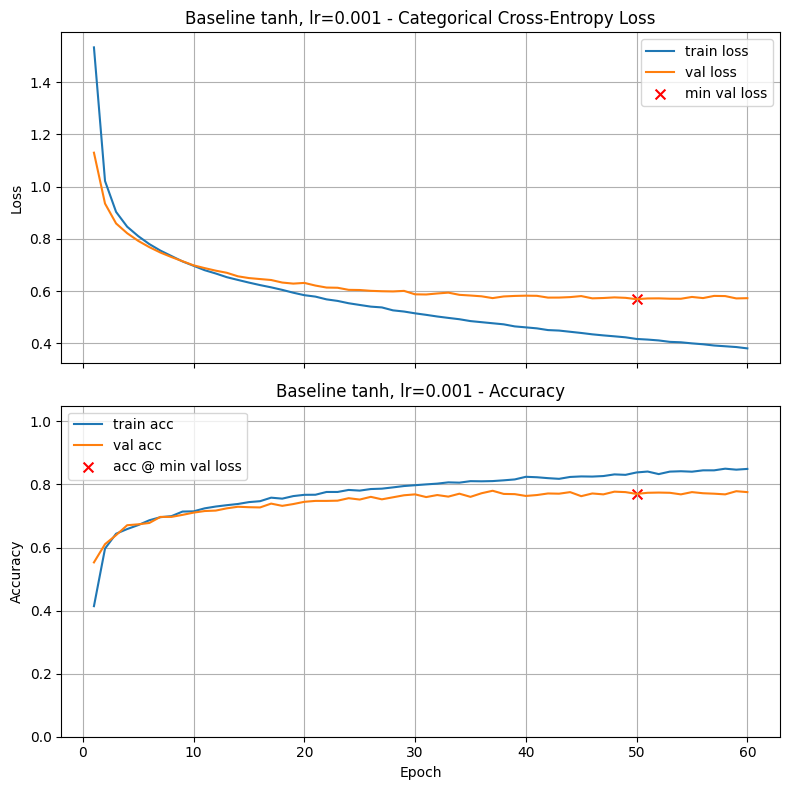

Final Training Loss:            0.3807
Final Training Accuracy:        0.8493
Final Validation Loss:          0.5730
Final Validation Accuracy:      0.7757
Minimum Validation Loss:        0.5691 (Epoch 50)
Validation Accuracy @ Min Loss: 0.7700

Test Loss: 0.5678
Test Accuracy: 0.7664

Validation-Test Gap (accuracy): 0.003571

Execution Time: 00:00:10

Baseline tanh, lr=0.0005



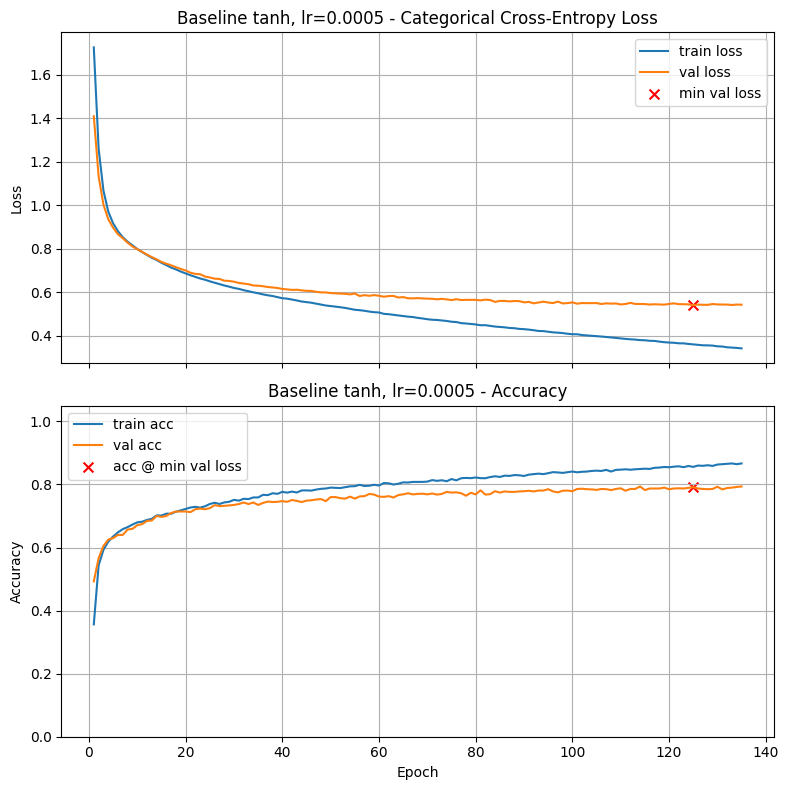

Final Training Loss:            0.3419
Final Training Accuracy:        0.8667
Final Validation Loss:          0.5428
Final Validation Accuracy:      0.7936
Minimum Validation Loss:        0.5406 (Epoch 125)
Validation Accuracy @ Min Loss: 0.7914

Test Loss: 0.5568
Test Accuracy: 0.7693

Validation-Test Gap (accuracy): 0.022143

Execution Time: 00:00:22

Baseline tanh, lr=0.0001



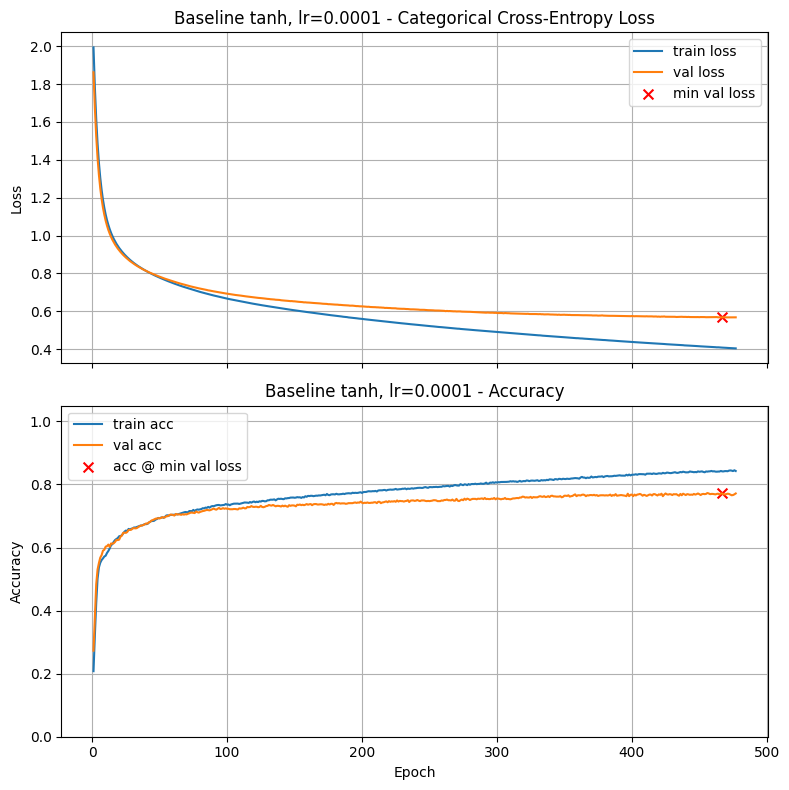

Final Training Loss:            0.4038
Final Training Accuracy:        0.8426
Final Validation Loss:          0.5678
Final Validation Accuracy:      0.7714
Minimum Validation Loss:        0.5670 (Epoch 467)
Validation Accuracy @ Min Loss: 0.7714

Test Loss: 0.5865
Test Accuracy: 0.7550

Validation-Test Gap (accuracy): 0.016429

Execution Time: 00:01:12

Baseline tanh, lr=5e-05



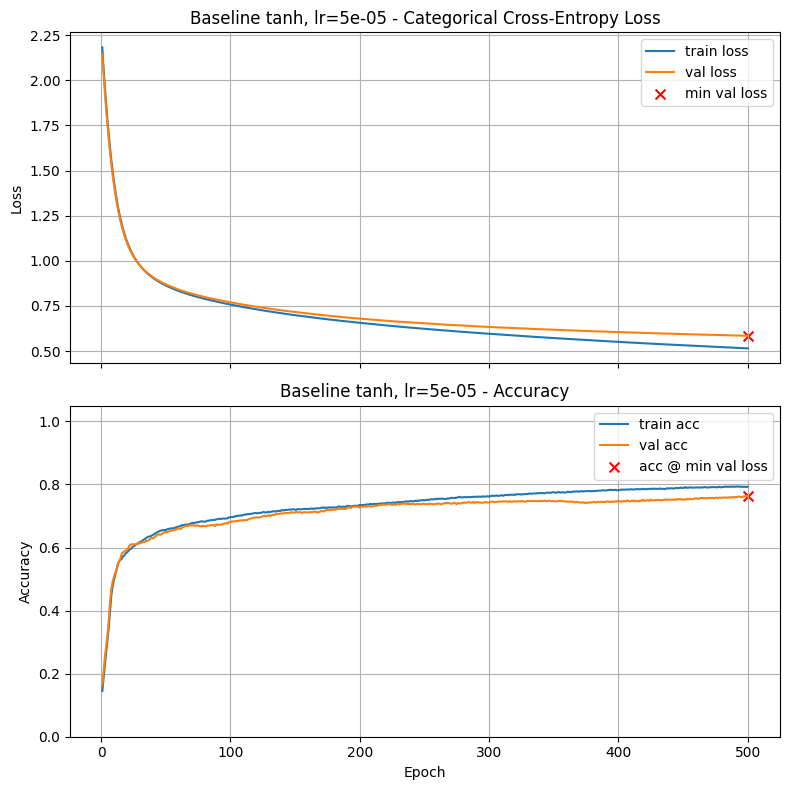

Final Training Loss:            0.5150
Final Training Accuracy:        0.7929
Final Validation Loss:          0.5845
Final Validation Accuracy:      0.7629
Minimum Validation Loss:        0.5845 (Epoch 500)
Validation Accuracy @ Min Loss: 0.7629

Test Loss: 0.6199
Test Accuracy: 0.7371

Validation-Test Gap (accuracy): 0.025714

Execution Time: 00:01:16

Baseline tanh, lr=1e-05



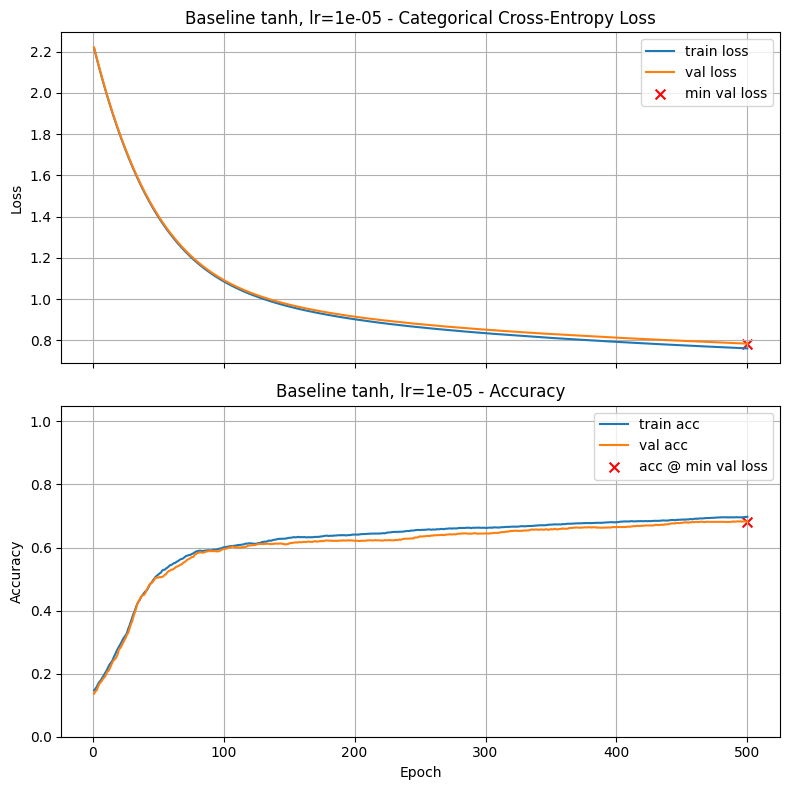

Final Training Loss:            0.7615
Final Training Accuracy:        0.6976
Final Validation Loss:          0.7845
Final Validation Accuracy:      0.6821
Minimum Validation Loss:        0.7845 (Epoch 500)
Validation Accuracy @ Min Loss: 0.6821

Test Loss: 0.7907
Test Accuracy: 0.6850

Validation-Test Gap (accuracy): 0.002857

Execution Time: 00:01:15

=== Validation accuracy at min val loss ===
Baseline tanh, lr=0.0005                	0.7914
Baseline tanh, lr=0.0001                	0.7714
Baseline tanh, lr=0.001                 	0.7700
Baseline tanh, lr=5e-05                 	0.7629
Baseline tanh, lr=1e-05                 	0.6821


In [23]:
# Your code here. Add as many cells as you need. 
# Clear previous results
results.clear()

learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]

for lr in learning_rates:
    model_es = build_model(
        n_inputs=X_train.shape[1],
        layer_list=[(64,'tanh',0.0,0.0), (32,'tanh',0.0,0.0)],
        n_classes=n_classes
    )
    train_and_test(model_es, 
                   title=f"Baseline tanh, lr={lr}", 
                   lr_schedule=lr)

print("\n=== Validation accuracy at min val loss ===")
print_results()

In [26]:
results['Baseline tanh, lr=0.0005'][0]

0.7914285659790039

In [27]:
print(5e-4)

0.0005


#### Graded Questions

In [28]:
# Set a2a to the learning rate which provided the best validation accuracy at the epoch of minimum validation loss

a2a = 5e-4           # Replace 0.0 with your answer

In [29]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a:.6f}') 

a2a = 0.000500


In [30]:
# Set a2b to the validation accuracy found by this best learning rate

a2b = results['Baseline tanh, lr=0.0005'][0]             # Replace 0.0 with your answer

In [31]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7914


### Problem Three: Dropout

In this problem, you will explore how **dropout** can help prevent overfitting in neural networks. There are no absolute rules, but some useful hueristics are:

* Dropout typically works best in **later dense layers** (e.g., the second hidden layer of width 32) in the range **0.3–0.5**.
* If applied to **earlier layers** (e.g., the first hidden layer), dropout should be smaller, typically **0.0–0.2** (where 0.0 means no dropout).

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate dropout in the ranges suggested, using increments of **0.1**.
* Identify which dropout configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Baseline tanh, lr=0.0005, d1=0.0, d2=0.3



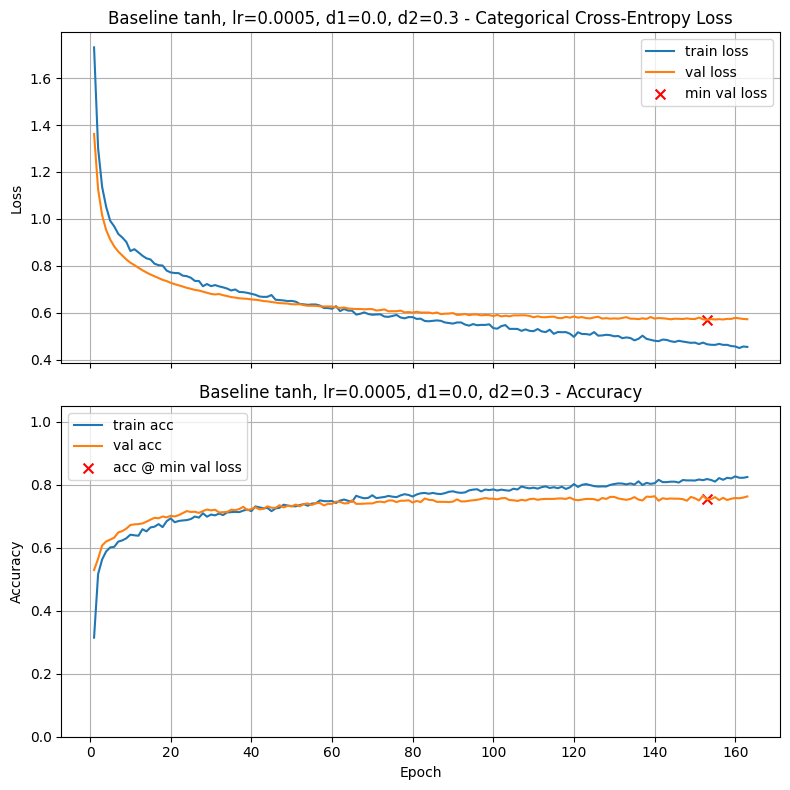

Final Training Loss:            0.4543
Final Training Accuracy:        0.8245
Final Validation Loss:          0.5723
Final Validation Accuracy:      0.7629
Minimum Validation Loss:        0.5699 (Epoch 153)
Validation Accuracy @ Min Loss: 0.7543

Test Loss: 0.6025
Test Accuracy: 0.7586

Validation-Test Gap (accuracy): 0.004286

Execution Time: 00:00:26

Baseline tanh, lr=0.0005, d1=0.0, d2=0.4



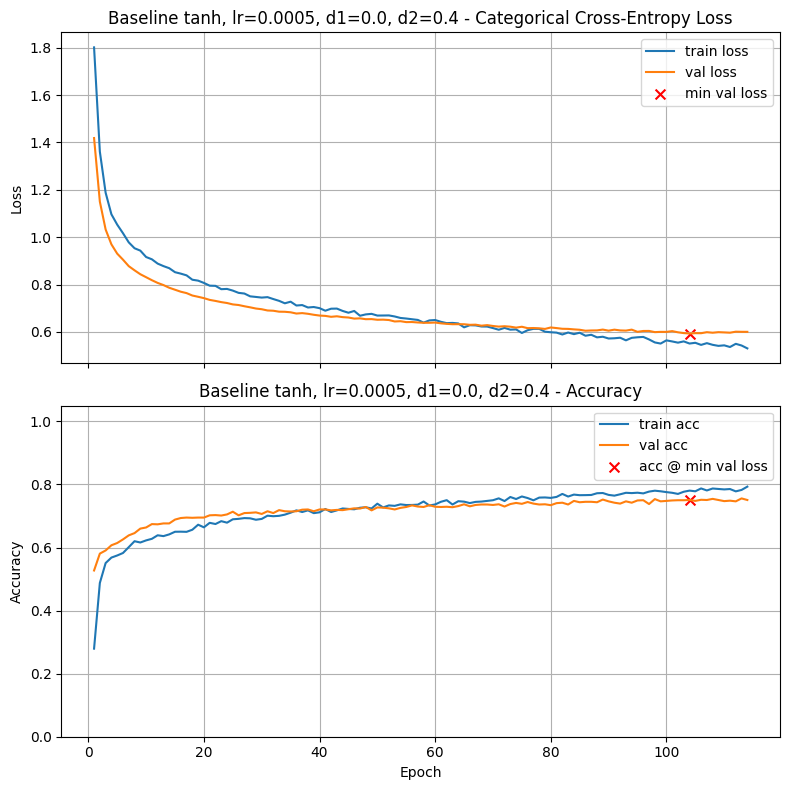

Final Training Loss:            0.5308
Final Training Accuracy:        0.7931
Final Validation Loss:          0.6006
Final Validation Accuracy:      0.7507
Minimum Validation Loss:        0.5936 (Epoch 104)
Validation Accuracy @ Min Loss: 0.7507

Test Loss: 0.6103
Test Accuracy: 0.7550

Validation-Test Gap (accuracy): 0.004286

Execution Time: 00:00:19

Baseline tanh, lr=0.0005, d1=0.0, d2=0.5



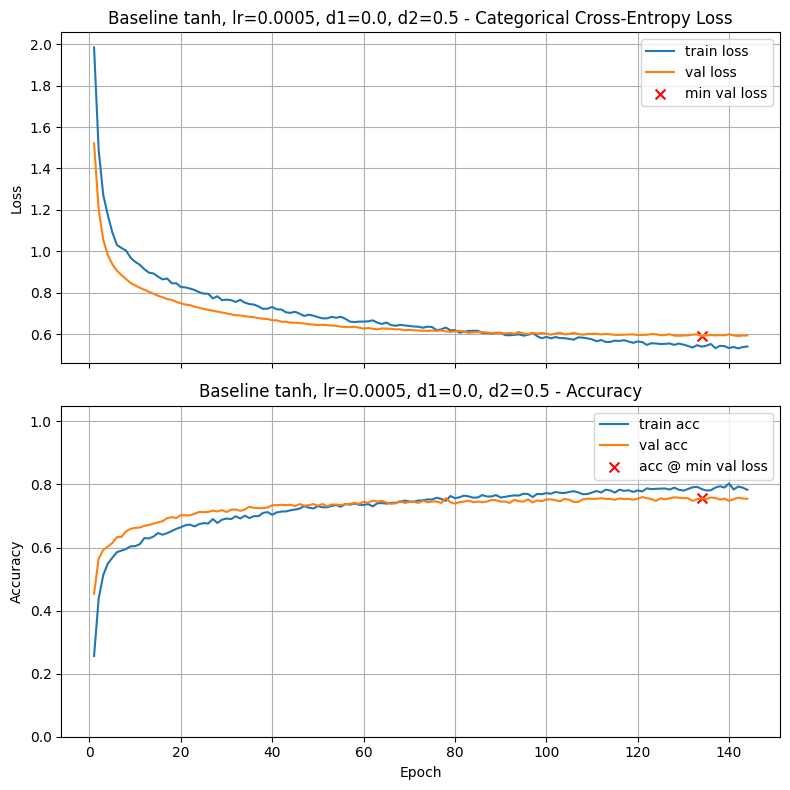

Final Training Loss:            0.5409
Final Training Accuracy:        0.7831
Final Validation Loss:          0.5939
Final Validation Accuracy:      0.7543
Minimum Validation Loss:        0.5904 (Epoch 134)
Validation Accuracy @ Min Loss: 0.7557

Test Loss: 0.6282
Test Accuracy: 0.7421

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:00:24

Baseline tanh, lr=0.0005, d1=0.1, d2=0.3



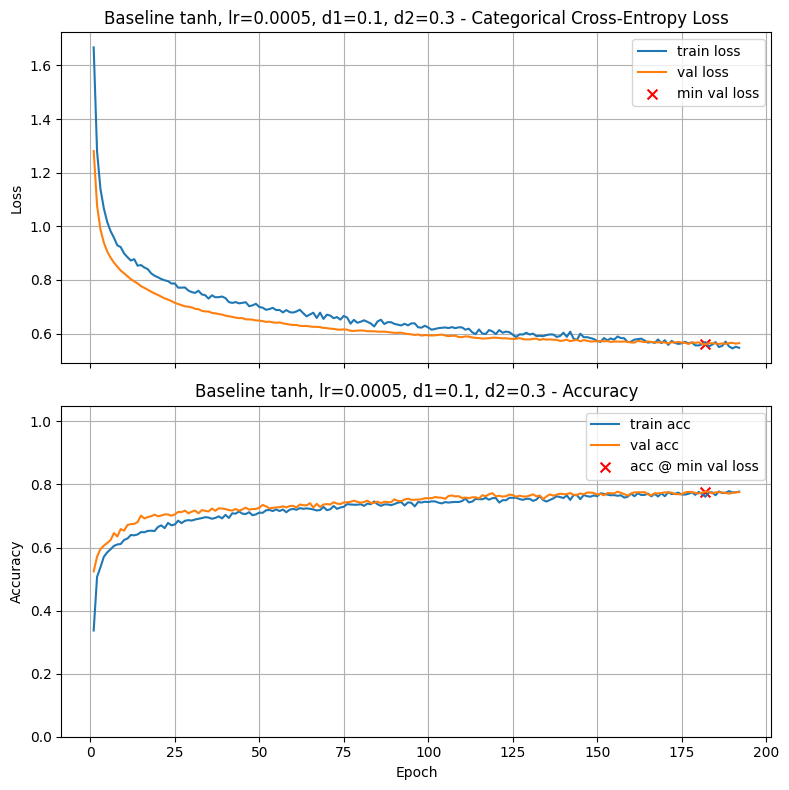

Final Training Loss:            0.5472
Final Training Accuracy:        0.7771
Final Validation Loss:          0.5649
Final Validation Accuracy:      0.7757
Minimum Validation Loss:        0.5602 (Epoch 182)
Validation Accuracy @ Min Loss: 0.7771

Test Loss: 0.5819
Test Accuracy: 0.7614

Validation-Test Gap (accuracy): 0.015714

Execution Time: 00:00:32

Baseline tanh, lr=0.0005, d1=0.1, d2=0.4



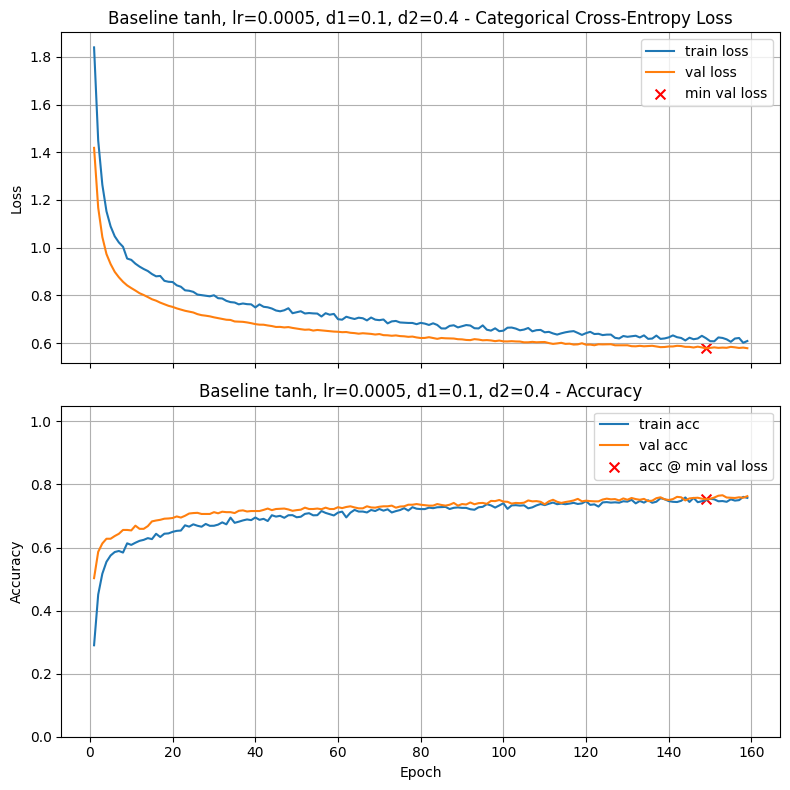

Final Training Loss:            0.6089
Final Training Accuracy:        0.7574
Final Validation Loss:          0.5787
Final Validation Accuracy:      0.7629
Minimum Validation Loss:        0.5780 (Epoch 149)
Validation Accuracy @ Min Loss: 0.7529

Test Loss: 0.6104
Test Accuracy: 0.7521

Validation-Test Gap (accuracy): 0.000714

Execution Time: 00:00:26

Baseline tanh, lr=0.0005, d1=0.1, d2=0.5



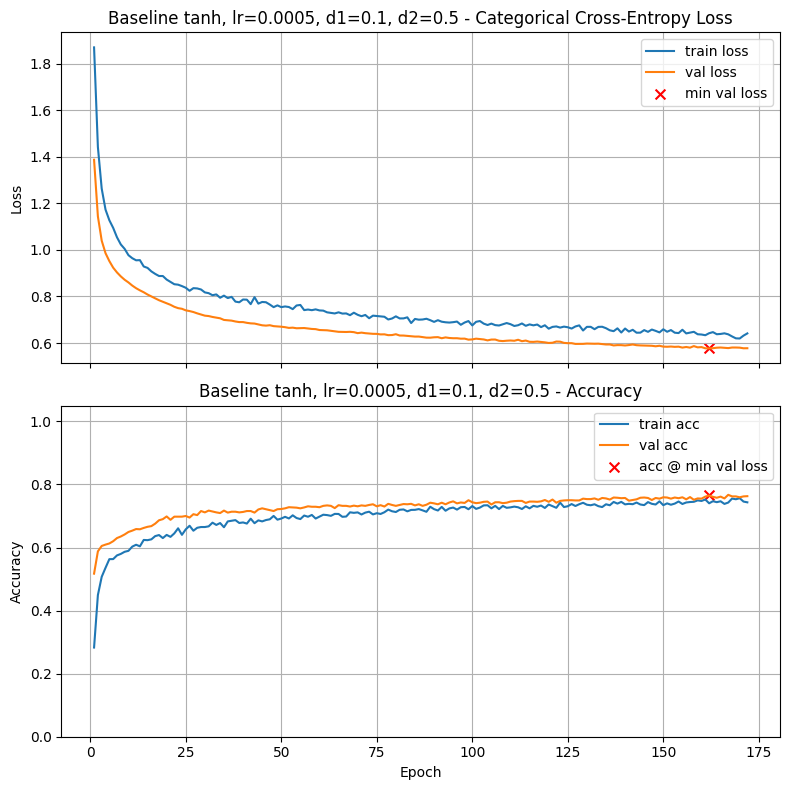

Final Training Loss:            0.6413
Final Training Accuracy:        0.7433
Final Validation Loss:          0.5776
Final Validation Accuracy:      0.7629
Minimum Validation Loss:        0.5770 (Epoch 162)
Validation Accuracy @ Min Loss: 0.7650

Test Loss: 0.6142
Test Accuracy: 0.7443

Validation-Test Gap (accuracy): 0.020714

Execution Time: 00:00:28

Baseline tanh, lr=0.0005, d1=0.2, d2=0.3



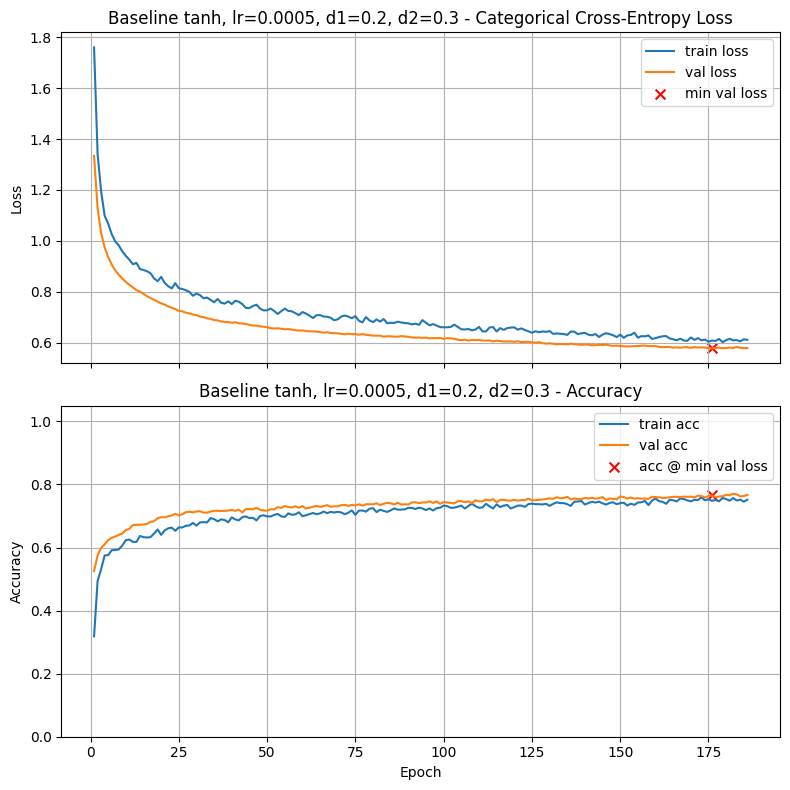

Final Training Loss:            0.6118
Final Training Accuracy:        0.7517
Final Validation Loss:          0.5794
Final Validation Accuracy:      0.7664
Minimum Validation Loss:        0.5780 (Epoch 176)
Validation Accuracy @ Min Loss: 0.7650

Test Loss: 0.6054
Test Accuracy: 0.7514

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:00:31

Baseline tanh, lr=0.0005, d1=0.2, d2=0.4



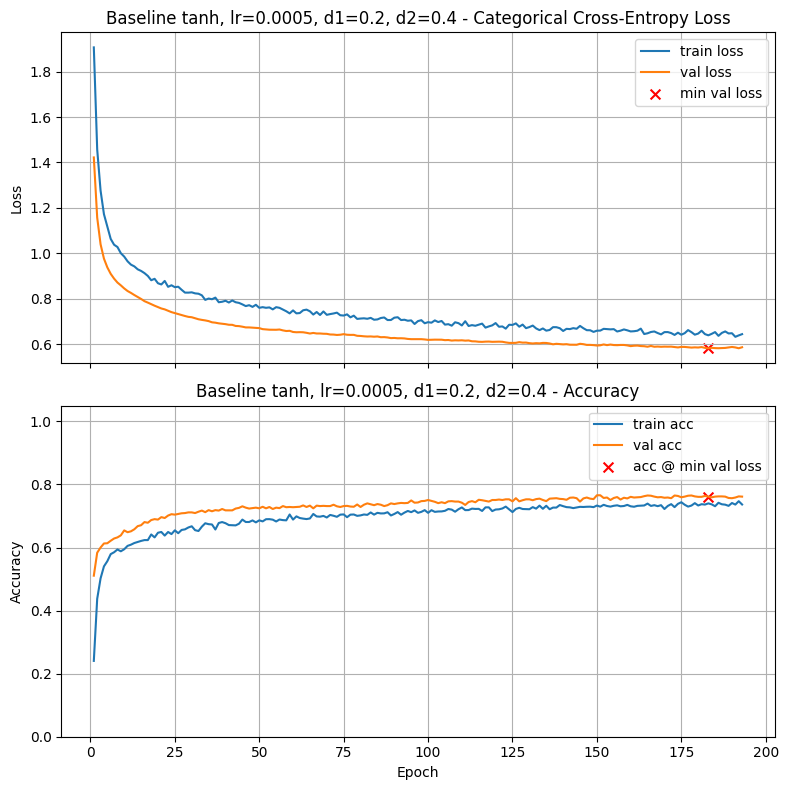

Final Training Loss:            0.6442
Final Training Accuracy:        0.7364
Final Validation Loss:          0.5865
Final Validation Accuracy:      0.7614
Minimum Validation Loss:        0.5815 (Epoch 183)
Validation Accuracy @ Min Loss: 0.7614

Test Loss: 0.6242
Test Accuracy: 0.7407

Validation-Test Gap (accuracy): 0.020714

Execution Time: 00:00:32

Baseline tanh, lr=0.0005, d1=0.2, d2=0.5



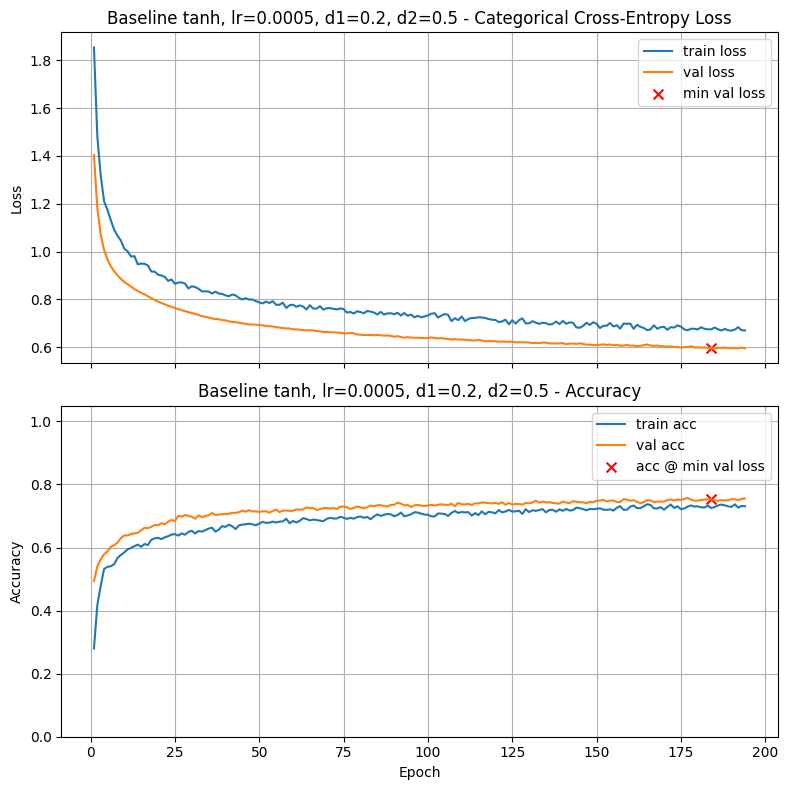

Final Training Loss:            0.6702
Final Training Accuracy:        0.7310
Final Validation Loss:          0.5956
Final Validation Accuracy:      0.7557
Minimum Validation Loss:        0.5951 (Epoch 184)
Validation Accuracy @ Min Loss: 0.7529

Test Loss: 0.6369
Test Accuracy: 0.7336

Validation-Test Gap (accuracy): 0.019286

Execution Time: 00:00:32

=== Validation accuracy at min val loss ===
Baseline tanh, lr=0.0005, d1=0.1, d2=0.3	0.7771
Baseline tanh, lr=0.0005, d1=0.1, d2=0.5	0.7650
Baseline tanh, lr=0.0005, d1=0.2, d2=0.3	0.7650
Baseline tanh, lr=0.0005, d1=0.2, d2=0.4	0.7614
Baseline tanh, lr=0.0005, d1=0.0, d2=0.5	0.7557
Baseline tanh, lr=0.0005, d1=0.0, d2=0.3	0.7543
Baseline tanh, lr=0.0005, d1=0.1, d2=0.4	0.7529
Baseline tanh, lr=0.0005, d1=0.2, d2=0.5	0.7529
Baseline tanh, lr=0.0005, d1=0.0, d2=0.4	0.7507


In [32]:
# Your code here. Add as many cells as you need. 
results.clear()

# dropout options to test
dropout_first_layer = [0.0, 0.1, 0.2]   # early layer (64)
dropout_second_layer = [0.3, 0.4, 0.5]  # later layer (32)

for d1 in dropout_first_layer:
    for d2 in dropout_second_layer:
        model_do = build_model(
            n_inputs=X_train.shape[1],
            layer_list=[(64,'tanh',0.0,d1), (32,'tanh',0.0,d2)],
            n_classes=n_classes
        )
        train_and_test(model_do, 
                       title=f"Baseline tanh, lr=0.0005, d1={d1}, d2={d2}", 
                       lr_schedule=0.0005)

print("\n=== Validation accuracy at min val loss ===")
print_results()

In [33]:
# Set a3a to the pair (dropout_rate_64,dropout_rate_32) of dropout rates for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a3a = (0.1, 0.3) # Replace (0.0,0.0) with your answer

In [34]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a}') 

a3a = (0.1, 0.3)


In [35]:
# Set a3b to the validation accuracy found by this best pair of dropout rates

a3b = 0.7771            # Replace 0.0 with your answer

In [36]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.7771


### Problem Four: L2 Regularization

In this problem, you will explore how **L2 regularization** (also called *weight decay*) can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Start simple by using the **same λ in both hidden layers**, with values:

  ```
      1e-4, 1e-3, 1e-2
  ```

* If validation results suggest underfitting in the first layer or persistent overfitting in the later one, then try adjusting per layer, for example:

  * First hidden layer: λ = 1e-4
  * Second hidden layer: λ = 1e-3

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**, but **without dropout**.
* Investigate at least the four cases suggested (three with the same λ and one with different λ values). You may also consider additional combinations.
* Identify which configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Baseline tanh, lr=0.0005, λ=0.0001



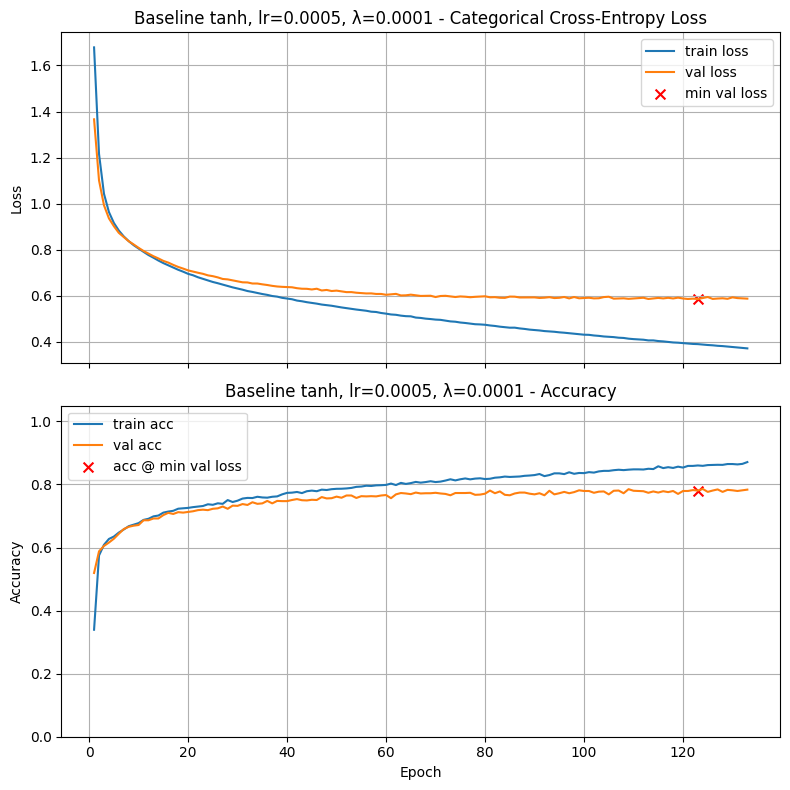

Final Training Loss:            0.3705
Final Training Accuracy:        0.8710
Final Validation Loss:          0.5867
Final Validation Accuracy:      0.7836
Minimum Validation Loss:        0.5851 (Epoch 123)
Validation Accuracy @ Min Loss: 0.7807

Test Loss: 0.5810
Test Accuracy: 0.7643

Validation-Test Gap (accuracy): 0.016429

Execution Time: 00:00:22

Baseline tanh, lr=0.0005, λ=0.001



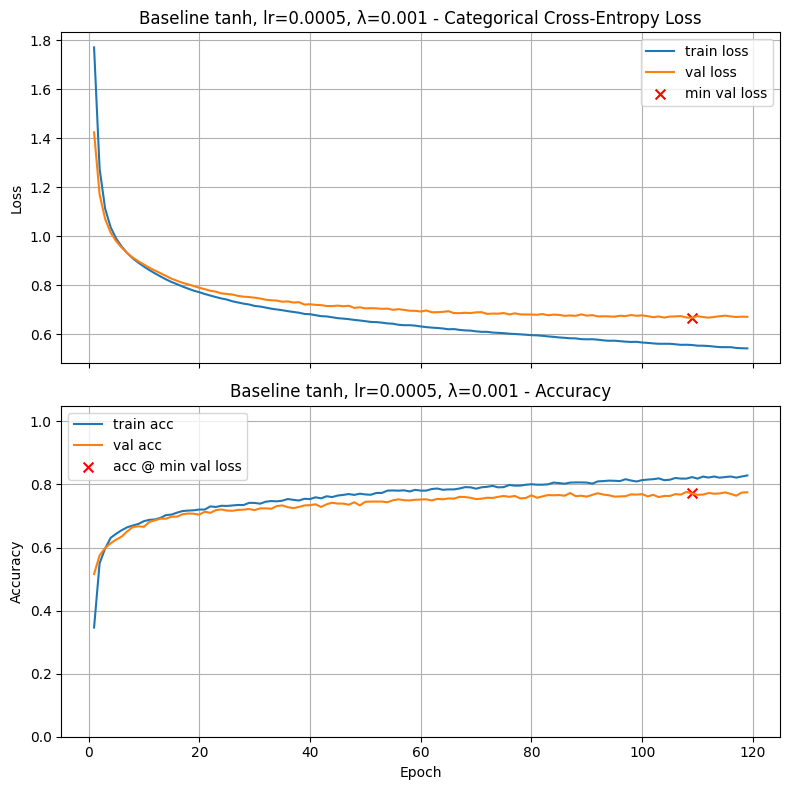

Final Training Loss:            0.5415
Final Training Accuracy:        0.8286
Final Validation Loss:          0.6703
Final Validation Accuracy:      0.7750
Minimum Validation Loss:        0.6663 (Epoch 109)
Validation Accuracy @ Min Loss: 0.7714

Test Loss: 0.6816
Test Accuracy: 0.7557

Validation-Test Gap (accuracy): 0.015714

Execution Time: 00:00:19

Baseline tanh, lr=0.0005, λ=0.01



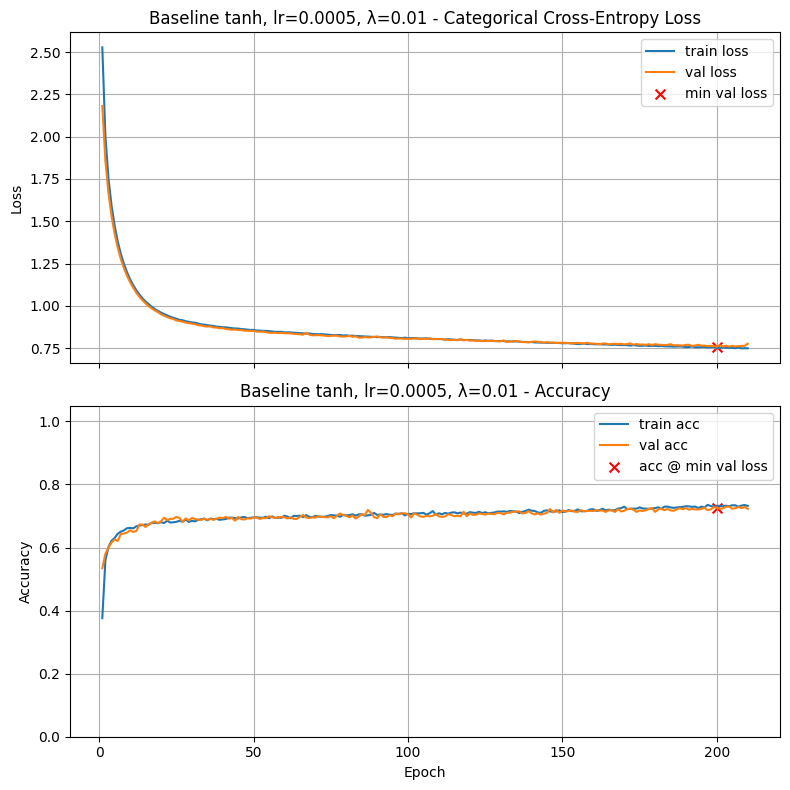

Final Training Loss:            0.7495
Final Training Accuracy:        0.7319
Final Validation Loss:          0.7764
Final Validation Accuracy:      0.7229
Minimum Validation Loss:        0.7594 (Epoch 200)
Validation Accuracy @ Min Loss: 0.7264

Test Loss: 0.7892
Test Accuracy: 0.7214

Validation-Test Gap (accuracy): 0.005000

Execution Time: 00:00:33

Baseline tanh, lr=0.0005, λ1=1e-4, λ2=1e-3



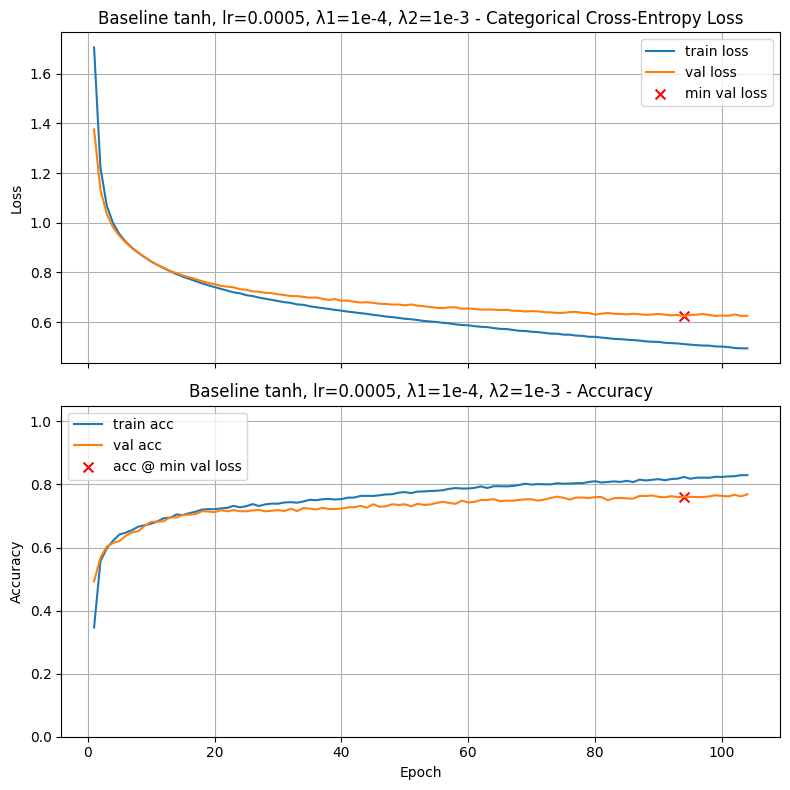

Final Training Loss:            0.4941
Final Training Accuracy:        0.8295
Final Validation Loss:          0.6253
Final Validation Accuracy:      0.7686
Minimum Validation Loss:        0.6240 (Epoch 94)
Validation Accuracy @ Min Loss: 0.7607

Test Loss: 0.6423
Test Accuracy: 0.7443

Validation-Test Gap (accuracy): 0.016429

Execution Time: 00:00:17

=== Validation accuracy at min val loss ===
Baseline tanh, lr=0.0005, λ=0.0001      	0.7807
Baseline tanh, lr=0.0005, λ=0.001       	0.7714
Baseline tanh, lr=0.0005, λ1=1e-4, λ2=1e-3	0.7607
Baseline tanh, lr=0.0005, λ=0.01        	0.7264


In [37]:
# Your code here. Add as many cells as you need. 
# Clear results
results.clear()

# Candidate λ values
l2_values = [1e-4, 1e-3, 1e-2]

# 1. Same λ for both hidden layers
for lam in l2_values:
    model_l2 = build_model(
        n_inputs=X_train.shape[1],
        layer_list=[(64,'tanh',lam,0.0), (32,'tanh',lam,0.0)],
        n_classes=n_classes
    )
    train_and_test(model_l2, 
                   title=f"Baseline tanh, lr=0.0005, λ={lam}", 
                   lr_schedule=0.0005)

# 2. Mixed λ (example: smaller in first, larger in second)
model_l2_mix = build_model(
    n_inputs=X_train.shape[1],
    layer_list=[(64,'tanh',1e-4,0.0), (32,'tanh',1e-3,0.0)],
    n_classes=n_classes
)
train_and_test(model_l2_mix, 
               title="Baseline tanh, lr=0.0005, λ1=1e-4, λ2=1e-3", 
               lr_schedule=0.0005)

print("\n=== Validation accuracy at min val loss ===")
print_results()

In [38]:
# Set a4a to the pair (L2_lambda_64,L2_lambda_32) of the L2 lambdas for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a4a = (0.0001, 0.0001)            # Replace (0.0,0.0) with your answer

In [39]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a}') 

a4a = (0.0001, 0.0001)


In [40]:
# Set a4b to the validation accuracy found by this best pair of lambdas

a4b = 0.7807           # Replace 0.0 with your answer

In [41]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.7807


### Problem Five: Combining Dropout with L2 Regularization

In this problem, you will explore how **dropout** and **L2 regularization** can work together to prevent overfitting. These two methods complement each other, but must be balanced carefully. A useful rule of thumb is:

* If dropout is **high**, use a **smaller λ**.
* If dropout is **low**, you can afford a **larger λ**.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate combinations of dropout and L2:

  * First, use the **dropout rate you identified in Problem Three** as a baseline.
  * Then, add L2 to both hidden layers with values:

    ```
        1e-4, 1e-3, 1e-2
    ```

    while keeping dropout fixed.
  * Finally, try **reducing dropout slightly** when L2 is added to see if performance improves.
  * [Optional] You may wish to investigate other combinations not covered here; for example, promising but not optimal choices of dropout rates may provide overall better performance when combines with L2 Regulari 
* Identify which combination produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.




Baseline tanh, lr=0.0005, d1=0.1, d2=0.3, no L2



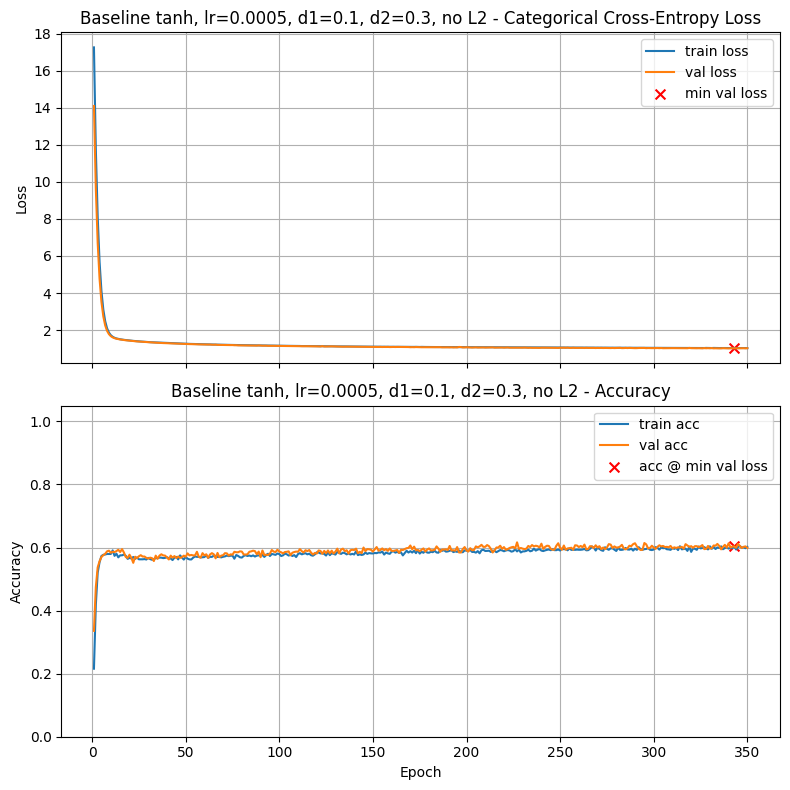

Final Training Loss:            1.0274
Final Training Accuracy:        0.6021
Final Validation Loss:          1.0215
Final Validation Accuracy:      0.5986
Minimum Validation Loss:        1.0112 (Epoch 343)
Validation Accuracy @ Min Loss: 0.6036

Test Loss: 1.0352
Test Accuracy: 0.6064

Validation-Test Gap (accuracy): 0.007143

Execution Time: 00:00:55


In [42]:
# Your code here. Add as many cells as you need.
results.clear()

model_base = build_model(
    n_inputs=X_train.shape[1],
    layer_list=[(64,'tanh',0.1,0.0), (32,'tanh',0.3,0.0)],
    n_classes=n_classes
)
train_and_test(model_base, title="Baseline tanh, lr=0.0005, d1=0.1, d2=0.3, no L2", lr_schedule=0.0005)



tanh, lr=0.0005, d1=0.1, d2=0.3, λ=0.0001



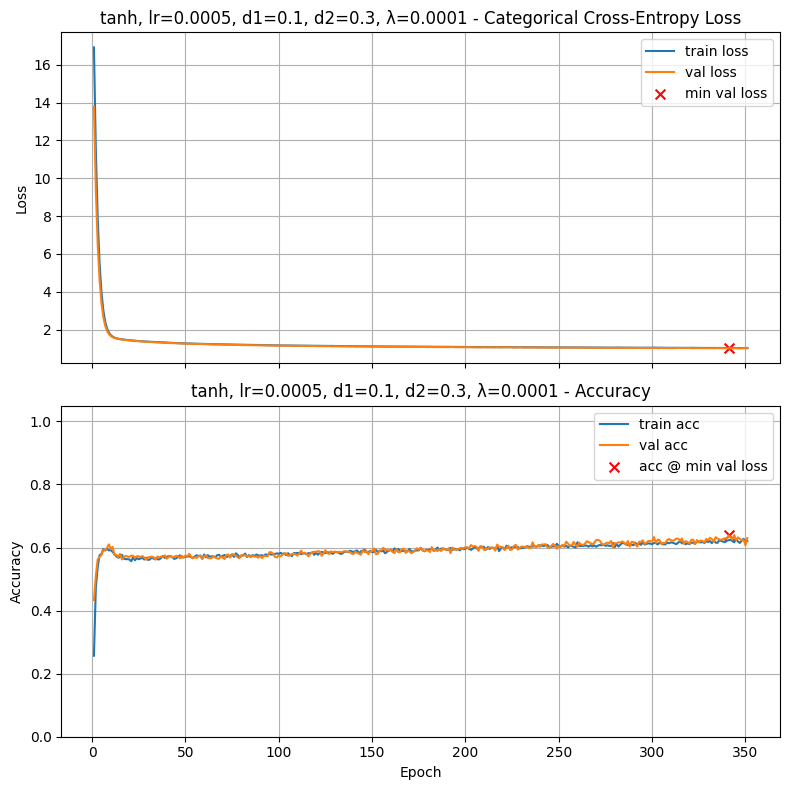

Final Training Loss:            1.0331
Final Training Accuracy:        0.6205
Final Validation Loss:          1.0140
Final Validation Accuracy:      0.6300
Minimum Validation Loss:        1.0116 (Epoch 341)
Validation Accuracy @ Min Loss: 0.6386

Test Loss: 1.0514
Test Accuracy: 0.6150

Validation-Test Gap (accuracy): 0.023571

Execution Time: 00:00:58

tanh, lr=0.0005, d1=0.1, d2=0.3, λ=0.001



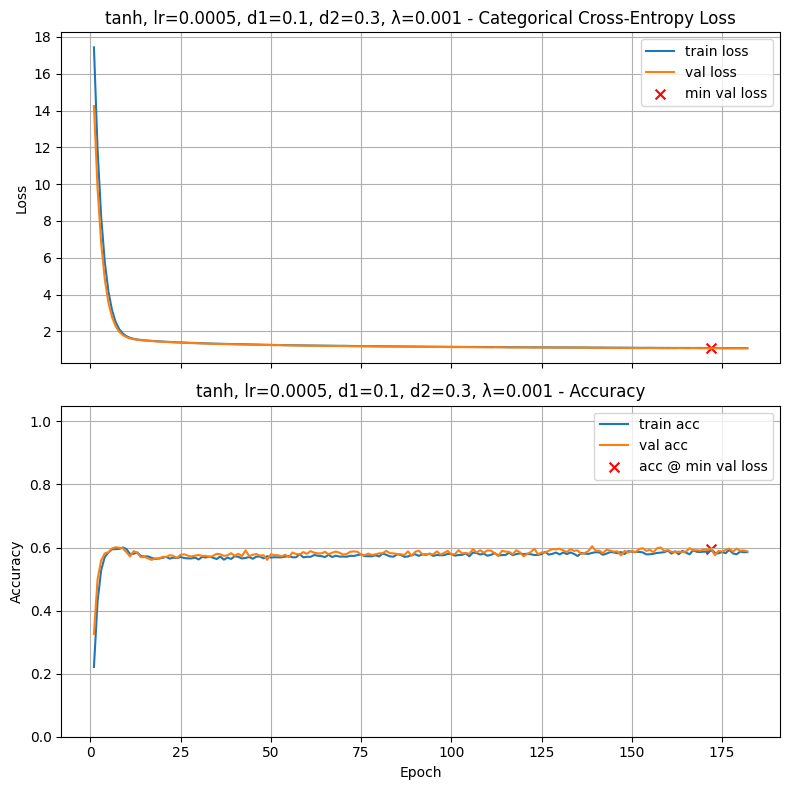

Final Training Loss:            1.0908
Final Training Accuracy:        0.5855
Final Validation Loss:          1.0828
Final Validation Accuracy:      0.5879
Minimum Validation Loss:        1.0789 (Epoch 172)
Validation Accuracy @ Min Loss: 0.5964

Test Loss: 1.1003
Test Accuracy: 0.5921

Validation-Test Gap (accuracy): 0.004286

Execution Time: 00:00:31

tanh, lr=0.0005, d1=0.1, d2=0.3, λ=0.01



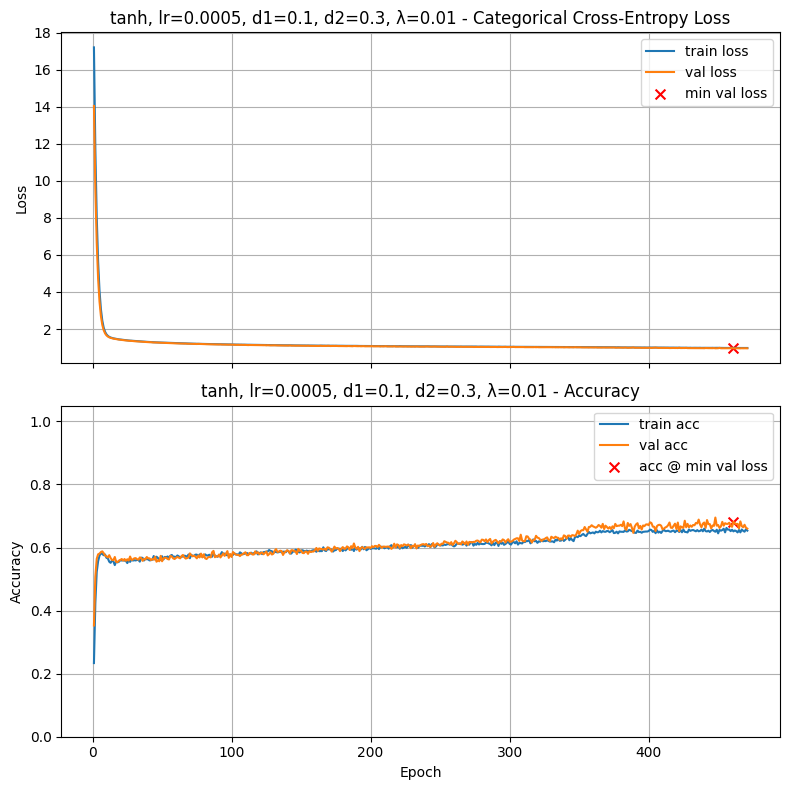

Final Training Loss:            0.9788
Final Training Accuracy:        0.6536
Final Validation Loss:          0.9616
Final Validation Accuracy:      0.6600
Minimum Validation Loss:        0.9574 (Epoch 461)
Validation Accuracy @ Min Loss: 0.6814

Test Loss: 0.9896
Test Accuracy: 0.6479

Validation-Test Gap (accuracy): 0.033571

Execution Time: 00:01:15


In [43]:
for lam in [1e-4, 1e-3, 1e-2]:
    model_l2 = build_model(
        n_inputs=X_train.shape[1],
        layer_list=[(64,'tanh',0.1,lam), (32,'tanh',0.3,lam)],
        n_classes=n_classes
    )
    train_and_test(model_l2, 
                   title=f"tanh, lr=0.0005, d1=0.1, d2=0.3, λ={lam}", 
                   lr_schedule=0.0005)



tanh, lr=0.0005, d1=0.0, d2=0.2, λ=0.0001



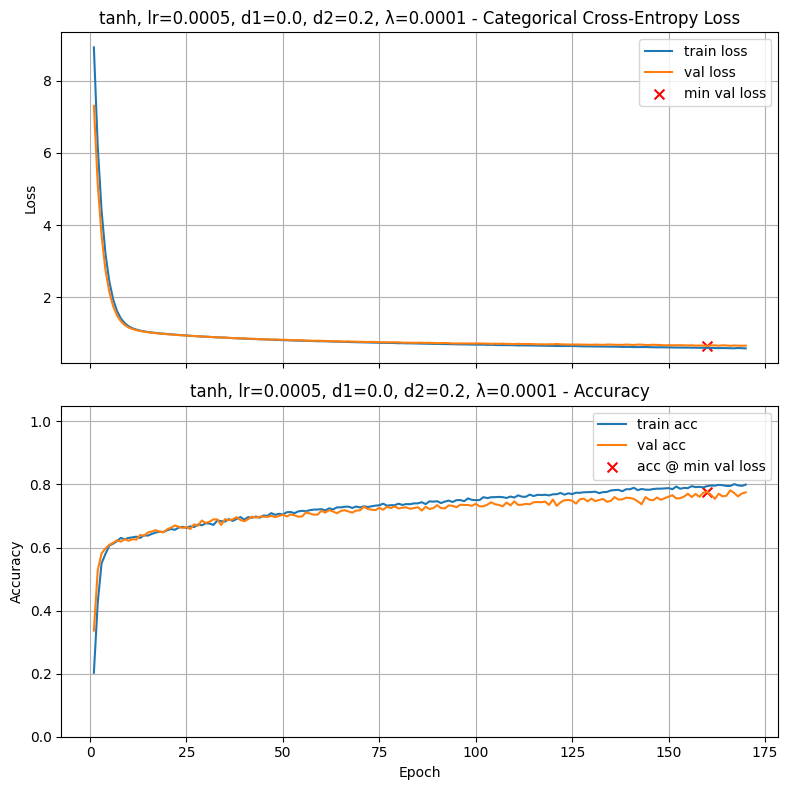

Final Training Loss:            0.5846
Final Training Accuracy:        0.7995
Final Validation Loss:          0.6606
Final Validation Accuracy:      0.7750
Minimum Validation Loss:        0.6552 (Epoch 160)
Validation Accuracy @ Min Loss: 0.7764

Test Loss: 0.6803
Test Accuracy: 0.7493

Validation-Test Gap (accuracy): 0.027143

Execution Time: 00:00:30

tanh, lr=0.0005, d1=0.0, d2=0.2, λ=0.001



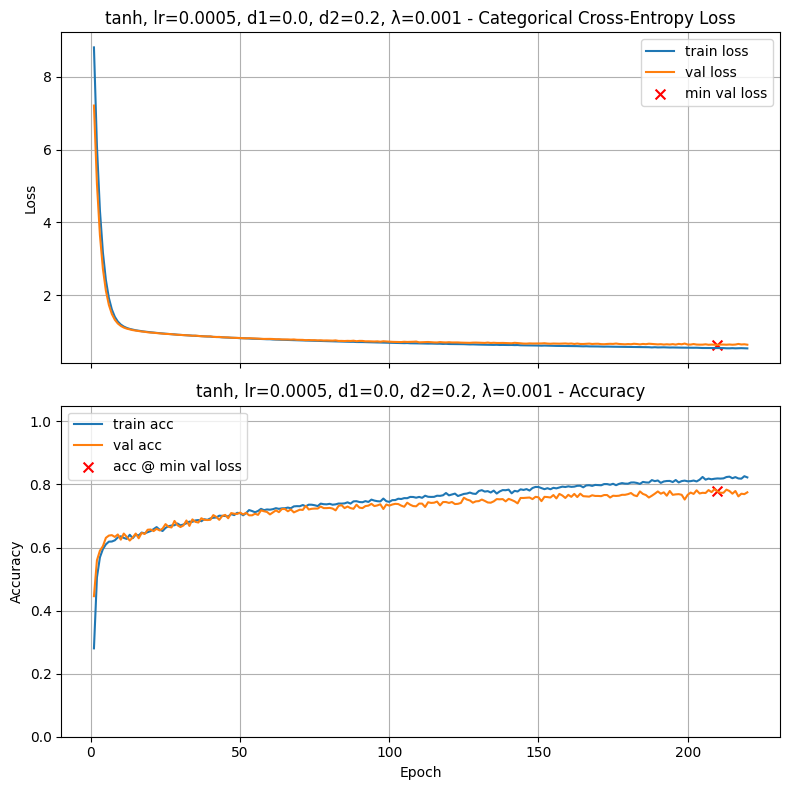

Final Training Loss:            0.5354
Final Training Accuracy:        0.8224
Final Validation Loss:          0.6363
Final Validation Accuracy:      0.7750
Minimum Validation Loss:        0.6328 (Epoch 210)
Validation Accuracy @ Min Loss: 0.7779

Test Loss: 0.6579
Test Accuracy: 0.7529

Validation-Test Gap (accuracy): 0.025000

Execution Time: 00:00:36

tanh, lr=0.0005, d1=0.0, d2=0.2, λ=0.01



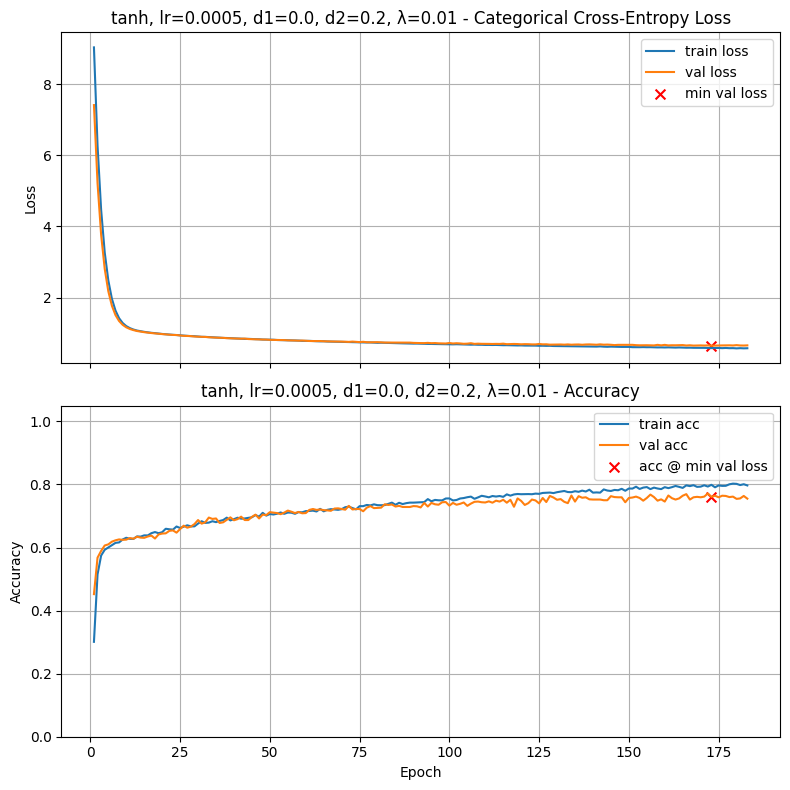

Final Training Loss:            0.5819
Final Training Accuracy:        0.7969
Final Validation Loss:          0.6622
Final Validation Accuracy:      0.7550
Minimum Validation Loss:        0.6538 (Epoch 173)
Validation Accuracy @ Min Loss: 0.7607

Test Loss: 0.6802
Test Accuracy: 0.7364

Validation-Test Gap (accuracy): 0.024286

Execution Time: 00:00:30


In [44]:
for lam in [1e-4, 1e-3, 1e-2]:
    model_drop_l2 = build_model(
        n_inputs=X_train.shape[1],
        layer_list=[(64,'tanh',0.0,lam), (32,'tanh',0.2,lam)],
        n_classes=n_classes
    )
    train_and_test(model_drop_l2, 
                   title=f"tanh, lr=0.0005, d1=0.0, d2=0.2, λ={lam}", 
                   lr_schedule=0.0005)


In [46]:
print_results()

tanh, lr=0.0005, d1=0.0, d2=0.2, λ=0.001	0.7779
tanh, lr=0.0005, d1=0.0, d2=0.2, λ=0.0001	0.7764
tanh, lr=0.0005, d1=0.0, d2=0.2, λ=0.01 	0.7607
tanh, lr=0.0005, d1=0.1, d2=0.3, λ=0.01 	0.6814
tanh, lr=0.0005, d1=0.1, d2=0.3, λ=0.0001	0.6386
Baseline tanh, lr=0.0005, d1=0.1, d2=0.3, no L2	0.6036
tanh, lr=0.0005, d1=0.1, d2=0.3, λ=0.001	0.5964


In [47]:
# Set a5 to the validation accuracy found by this best combination of dropout and L2 regularization

a5 = 0.7779             # Replace 0.0 with your answer

In [48]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5 = {a5:.4f}') 

a5 = 0.7779


### Problem Six: Build and Train Your Best Model

In this final problem, you will design and train your **best-performing model** using the techniques explored in the previous problems. You may make your own choices for:

* **Model architecture** (number of layers, widths, etc.)
* **Learning rate**
* **Batch size** (a new hyperparameter not varied in earlier problems)
* **Dropout rates** in both layers
* **L2 λ values** in both layers
* **[Optional but strongly suggested]:** Learning rate scheduling, using either **Exponential Decay** or **Cosine Decay**.

  * For Exponential Decay, typical decay rates are **0.90–0.999**, with **0.95** often a good starting point.

**Steps to follow:**

* Build and train the model according to your design choices.
* Use early stopping as before to evaluate performance at the epoch of **minimum validation loss**.
* Answer the graded question.



Best Model (tanh, lr=0.0005→decay, dropout+L2)



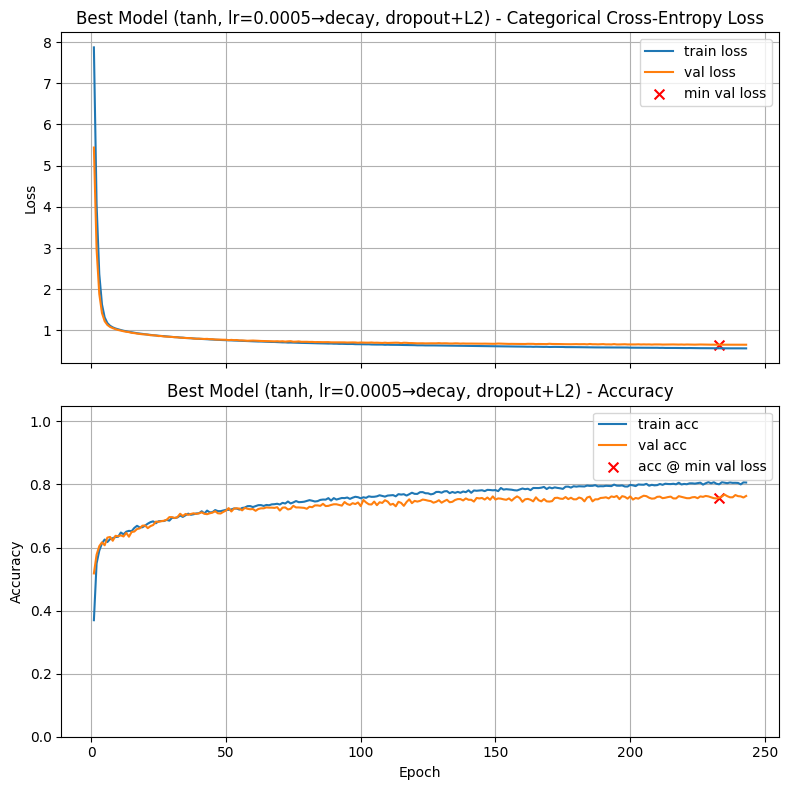

Final Training Loss:            0.5623
Final Training Accuracy:        0.8062
Final Validation Loss:          0.6508
Final Validation Accuracy:      0.7636
Minimum Validation Loss:        0.6500 (Epoch 233)
Validation Accuracy @ Min Loss: 0.7579

Test Loss: 0.6699
Test Accuracy: 0.7421

Validation-Test Gap (accuracy): 0.015714

Execution Time: 00:01:04


In [49]:
# Your code here
results.clear()

import tensorflow as tf

# define exponential decay schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=1000,   # adjust depending on dataset size
    decay_rate=0.95,
    staircase=True
)

best_model = build_model(
    n_inputs=X_train.shape[1],
    layer_list=[(64,'tanh',0.0,0.001),   # first hidden layer
                (32,'tanh',0.2,0.001)], # second hidden layer
    n_classes=n_classes
)

train_and_test(best_model,
               title="Best Model (tanh, lr=0.0005→decay, dropout+L2)",
               lr_schedule=lr_schedule,
               batch_size=32)



In [50]:
# Set a6 to the validation accuracy found by this best model

a6 = 0.7579             # Replace 0.0 with your answer

In [51]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a6 = {a6:.4f}') 

a6 = 0.7579


### Optional: Print out your results of all experiments

In [52]:
print_results()

Best Model (tanh, lr=0.0005→decay, dropout+L2)	0.7579


## Reflection Questions (ungraded)

1. Activation Functions:

    - Why do you think one activation function worked better than the others for this task?
    
    - How might this choice differ for deeper or wider networks?

2. Learning Rate:

    - Would a much smaller learning rate (with many more epochs) likely produce better accuracy?
    
    - When is it worth training longer with a smaller step size, and when is it unnecessary?

3. Dropout vs. L2:

    - Which form of regularization — dropout or L2 — gave better results in your experiments?
    
    - Why might one method be more effective in this setting?

4. Combining Dropout and L2:

    - Why might the combination of dropout and L2 sometimes perform worse than using one method alone?
    
    - What does this tell you about the balance between bias and variance in regularization?

5. Best Model:

    - When you designed your best model, what trade-offs did you notice between model complexity, training stability, and generalization?
    
    - Did learning rate scheduling (if you tried it) improve results? Why might it help?